# 载入套件

In [2]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import DBSCAN

from typing import Dict
from tqdm.auto import tqdm

import numpy as np
import random
import pandas as pd
import ydata_profiling

import scienceplots
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import matplotlib.cm as cm

import torch
import os

%matplotlib inline

pd.plotting.register_matplotlib_converters()
sns.set_style("whitegrid")
sns.set_palette("RdBu")
sns.set(
    rc={'text.usetex': True},
    font="serif",
    font_scale=1.2
)

SEED = 20230723


def same_seed(seed=SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


same_seed()


## 数据预处理

In [3]:
features = pd.read_pickle('../Datasets/features_q1.pkl')
for aspect in ['duration', 'up_flow', 'down_flow', 'count']:
    cols = [i for i in features.columns if i.startswith(aspect)]
    features[cols] = (features[cols] - features[cols].values.mean()) / \
        features[cols].values.std()


### 皮尔逊相关系数

In [ ]:
# corr = features.drop(columns='uid').corr()
# mask = np.triu(np.ones_like(corr, dtype=bool))
# f, ax = plt.subplots(figsize=(11, 9))
# sns.heatmap(corr, mask=mask, cmap=sns.color_palette("coolwarm"), vmax=.3, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})

# plt.savefig("../Thesis/figures/heatmap_features.pdf",
#             dpi=400, bbox_inches='tight', pad_inches=0.005)


### 主成分分析

In [ ]:
# pca = PCA()
# pca.fit(features.drop(columns='uid'))
# fs = np.arange(pca.n_components_)[:40]

# plt.figure(figsize=(10, 3))
# g = sns.barplot(x=fs, y=pca.explained_variance_[:40])

# plt.savefig("../Thesis/figures/barplot_pca_features.pdf",
#             dpi=400, bbox_inches='tight', pad_inches=0.005)


In [4]:
pca = PCA(n_components=3)
pca.fit(features.drop(columns='uid'))
transformed = pca.transform(features.drop(columns='uid'))
X = transformed


# 聚类分析

## 原型聚类：K-Means++

In [ ]:
# Ks = range(2, 52)
# inertias = []
# scores = []

# for k in Ks:
#     model = KMeans(n_clusters=k, random_state=0, n_init="auto", max_iter=1000)
#     model.fit(X)
#     inertias.append(model.inertia_)
#     scores.append(metrics.calinski_harabasz_score(X, model.labels_))

# fig, axes = plt.subplots(1, 2, figsize=(12, 5.5))

# g = sns.lineplot(x=Ks, y=inertias, marker='o', ax=axes[0])
# g.set(
#     xlabel='number of clusters',
#     ylabel='inertia'
# )

# g = sns.lineplot(x=Ks, y=scores,
#                  marker='o', ax=axes[1])
# g.set(
#     xlabel='number of clusters',
#     ylabel='calinski harabasz score'
# )

# plt.savefig("../Thesis/figures/lineplot_Ks_inertias_CH.pdf",
#             dpi=400, bbox_inches='tight', pad_inches=0.005)


In [5]:
labels_kmeans = KMeans(n_clusters=5, random_state=0,
                       n_init="auto", max_iter=1000).fit_predict(transformed)
labels_kmeans


array([2, 0, 0, ..., 2, 2, 0], dtype=int32)

In [6]:
labels_kmeans.shape


(44253,)

## 密度聚类：DBSCAN

In [7]:
# from sklearn.neighbors import NearestNeighbors

# # ref: https://stackoverflow.com/questions/15050389/estimating-choosing-optimal-hyperparameters-for-dbscan
# k = 2 * X.shape[-1] - 1
# nbrs = NearestNeighbors(n_neighbors=k, radius=1.0).fit(X)
# distances, indices = nbrs.kneighbors(X)
# distances = np.sort(distances, axis=0)
# distances = distances[:, k-1]

# g = sns.relplot(
#     distances,
#     kind='line'
# )

# plt.axhline(y=2, linestyle=':')

# g.set(
#     xlabel='Index of Users in the dataset',
#     ylabel='Sorted {}-nearest Neighbor Distance'.format(k)
# )

# plt.savefig("../Thesis/figures/relplot_knn_distances.pdf",
#             dpi=400, bbox_inches='tight', pad_inches=0.005)


In [8]:
db = DBSCAN(eps=2, min_samples=6).fit(X)
labels_dbscan = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise_ = list(labels_dbscan).count(-1)

print(f"Estimated number of clusters: {n_clusters_}")
print(f"Estimated number of noise points: {n_noise_}")


Estimated number of clusters: 7
Estimated number of noise points: 539


In [9]:
set(labels_dbscan)


{-1, 0, 1, 2, 3, 4, 5, 6}

In [69]:
counter = {}
for i in labels_dbscan:
    counter[i] = counter.get(i, 0)+1
counter


{0: 43649, -1: 539, 1: 20, 6: 6, 4: 7, 2: 6, 3: 9, 5: 17}

##  层次聚类：BRICH

In [10]:
from sklearn.cluster import Birch
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

brc = Birch(n_clusters=None)
brc.fit(transformed)
labels_brc = brc.labels_
centroids = brc.subcluster_centers_

model = AgglomerativeClustering(n_clusters=6)
model = model.fit(centroids)


In [ ]:
# def plot_dendrogram(model, **kwargs):
#     # Create linkage matrix and then plot the dendrogram

#     # create the counts of samples under each node
#     counts = np.zeros(model.children_.shape[0])
#     n_samples = len(model.labels_)
#     for i, merge in enumerate(model.children_):
#         current_count = 0
#         for child_idx in merge:
#             if child_idx < n_samples:
#                 current_count += 1  # leaf node
#             else:
#                 current_count += counts[child_idx - n_samples]
#         counts[i] = current_count

#     linkage_matrix = np.column_stack(
#         [model.children_, model.distances_, counts]
#     ).astype(float)

#     # Plot the corresponding dendrogram
#     dendrogram(linkage_matrix, **kwargs)


# plt.figure(figsize=(15, 15))
# plt.title("Hierarchical Clustering Dendrogram")
# # plot the top p levels of the dendrogram
# plot_dendrogram(model, truncate_mode="level", p=6)
# plt.xlabel("Number of points in node")
# plt.xticks(rotation=90)
# plt.savefig("../Thesis/figures/dendrogram.pdf",
#             dpi=400, bbox_inches='tight', pad_inches=0.005)


In [11]:
labels_brc_agn = []
for i in labels_brc:
    labels_brc_agn.append(model.labels_[i])


In [12]:
set(labels_brc_agn)


{0, 1, 2, 3, 4, 5}

# 算法比较

## 内部评价指标

In [77]:
data = {
    'Method': ['K-Means++', 'DBSCAN', 'BIRCH+AGNES'],
    'Calinski-Harabasz': [],
    'Davies-Bouldin': [],
    'Silhouette': []
}

for labels in [labels_kmeans, labels_dbscan, labels_brc_agn]:
    data['Calinski-Harabasz'].append(
        metrics.calinski_harabasz_score(transformed, labels))
    data['Davies-Bouldin'].append(
        metrics.davies_bouldin_score(transformed, labels)
    )
    data['Silhouette'].append(
        metrics.silhouette_score(transformed, labels)
    )

df = pd.DataFrame(data)


In [79]:
print(df.to_latex())


\begin{tabular}{llrrr}
\toprule
 & Method & Calinski-Harabasz & Davies-Bouldin & Silhouette \\
\midrule
0 & K-Means++ & 32187.076682 & 0.766536 & 0.511919 \\
1 & DBSCAN & 2870.580217 & 2.817892 & 0.664019 \\
2 & BIRCH+AGNES & 24732.933816 & 0.860360 & 0.622801 \\
\bottomrule
\end{tabular}



## 3D

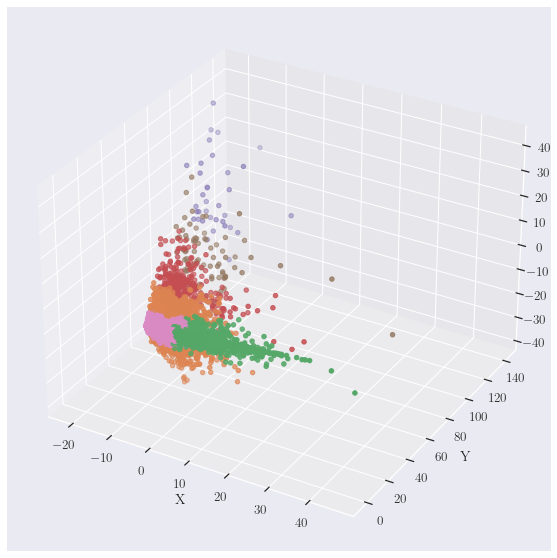

In [16]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ys = transformed[:, 0]
xs = transformed[:, 1]
zs = transformed[:, 2]
ax.scatter(xs, ys, zs,
           color=[f'C{i+1}' for i in labels_brc_agn])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.savefig("../Thesis/figures/3d_brc_agn.png",
            dpi=500, bbox_inches='tight', pad_inches=0.005)


## t-SNE

In [55]:
# from sklearn.manifold import TSNE

# # 大概需要运行5分钟
# X_embedded = TSNE(n_components=2, learning_rate='auto',
#                   random_state=0).fit_transform(transformed)
# np.save('t_SNE_X.npy', X_embedded)

X_embedded = np.load('t_SNE_X.npy')
x, y = X_embedded[:, 0], X_embedded[:, 1]


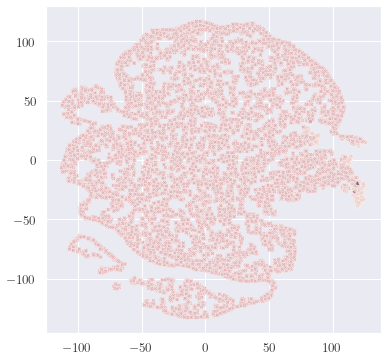

In [76]:
label = labels_dbscan
plt.figure(figsize=(6, 6))
sns.scatterplot(
    x=x,
    y=y,
    hue=label,
    size=0.2,
    style=label,
    alpha=0.75,
)
plt.legend([], [], frameon=False)
plt.savefig("../Thesis/figures/2d_dbscan.pdf",
            dpi=200, bbox_inches='tight', pad_inches=0.005)
